In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

from glob import glob
import seaborn as sns

import numpy as np
import pandas as pd

import warnings

from matplotlib import transforms

In [7]:
SECONDS_IN_YEAR = 60*60*24*365 #s
convert = lambda x: x * SECONDS_IN_YEAR * 1e-12 # kg -> Gt

AREA_of_EARTH = 510.1 * 1e6 #million km²

# data_path = "F:\\Local Data\\ClimateBench\\"
data_path = '../'

# Only future scenarios for now
inputs = glob(data_path + "inputs_s*.nc")

def get_rmse(truth, pred):
    return np.sqrt(((truth-pred)**2))

def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.latitude))
    return ds.weighted(weights).mean(['latitude', 'longitude'])

def global_sum(ds):
    weights = np.cos(np.deg2rad(ds.latitude))
    return ds.weighted(weights).sum(['latitude', 'longitude'])


In [9]:
print(inputs)

['../inputs_ssp370-lowNTCF.nc', '../inputs_ssp245.nc', '../inputs_ssp585.nc', '../inputs_ssp126.nc', '../inputs_ssp370.nc']


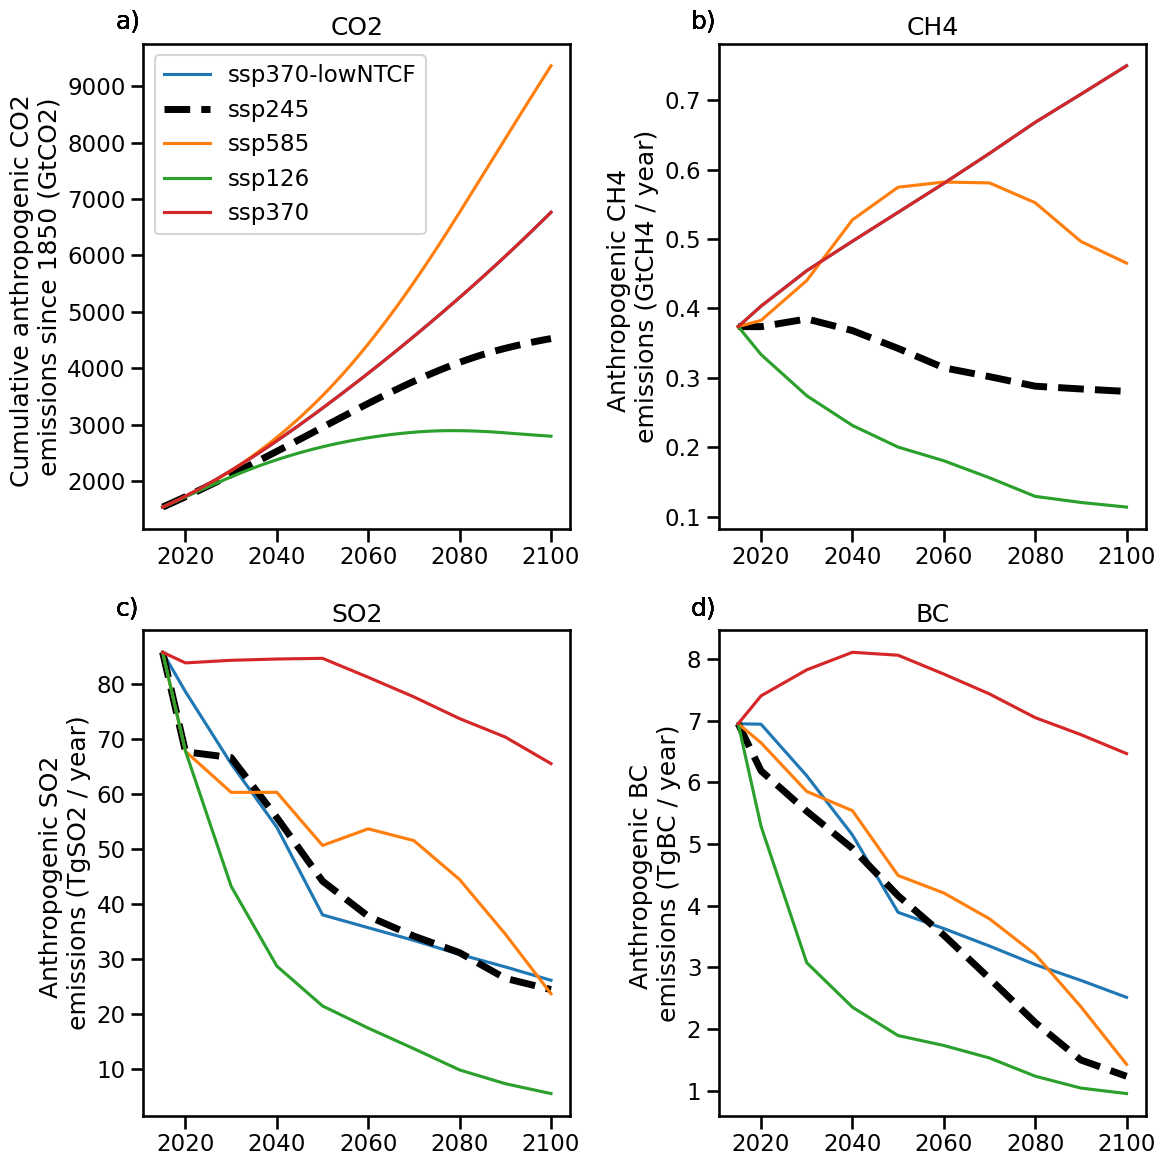

In [10]:

def add_label(label, ax=None, fig=None, fontsize='medium', va='bottom', x=0., y=1., **kwargs):
    if ax is None:
        ax = plt.gca()
    if fig is None:
        fig = plt.gcf()
    trans = transforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(x, y, label, transform=ax.transAxes + trans,
            fontsize=fontsize, va=va, **kwargs)
    
# for label, ax in zip(['a)', 'b)'], [ax1, ax2]):
#     # label physical distance to the left and up:
#     add_label(ax, label)


    
with sns.plotting_context("talk"):

    fig, axes = plt.subplots(2, 2, figsize=(12,12))

    for input in inputs:
        # label=input.split('_')[2][:-3]
        label = input.split('_')[1].split('.')[0]
        if label.startswith('ssp245-'):
            continue # Skip these idealised inputs 
        X = xr.open_dataset(input)
        x = range(2015, 2101)
        
        kwargs = {}
        if label == "ssp245":
            kwargs['color'] = 'black'
            kwargs['ls'] = '--'
            kwargs['lw'] = '5'
        axes[0, 0].plot(x, X['CO2'], label=label, **kwargs)
        axes[0, 0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
        add_label('a)', axes[0, 0])
        axes[0, 1].plot(x, X['CH4'], label=label, **kwargs)
        axes[0, 1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
        add_label('b)', axes[0, 1])
        # FIXME: Not sure where this factor of 1000 comes from...! Maybe the CEDS data is really g/m-2/s?
        axes[1, 0].plot(x, convert(global_sum(X['SO2']*AREA_of_EARTH*1000*100)), label=label, **kwargs)
        axes[1, 0].set_ylabel("Anthropogenic SO2 \nemissions (TgSO2 / year)")
        add_label('c)', axes[1, 0])
        axes[1, 1].plot(x, convert(global_sum(X['BC']*AREA_of_EARTH*1000*100)), label=label, **kwargs)
        axes[1, 1].set_ylabel("Anthropogenic BC \nemissions (TgBC / year)")
        add_label('d)', axes[1, 1])

    axes[0, 0].set_title('CO2')
    axes[0, 1].set_title('CH4')
    axes[1, 0].set_title('SO2')
    axes[1, 1].set_title('BC')
    axes[0, 0].legend()
    plt.tight_layout()
    
    plt.savefig("Figure_1.pdf")

In [17]:
all_inputs = glob(data_path + "inputs_*.nc")
global_means = {}

def global_total(da):
    if 'latitude' in da.coords:
        if da.name in ['CO2', 'CH4', 'tas']:
            return global_mean(da)
        else:
            return convert(global_sum(da*AREA_of_EARTH*1000*100))
    else:
        return da

# for inp in glob(data_path + "inputs_*.nc"):
#     label=inp.split('_')[3][:-3]
#     X = xr.open_dataset(inp)
#     Y = xr.open_dataset(data_path + f"outputs_{label}.nc")
# #     print(X.coords)
#     print(label)
# #     if label == "hist-aer":
# #         X = X.rename_vars({"CO4": "CO2"})
#     if 'lat' in X.coords:
#         X = X.rename({'lat': 'latitude', 'lon': 'longitude'})
#     if 'lat' in Y.coords:
#         Y = Y.rename({'lat': 'latitude', 'lon': 'longitude'})

#     if label == "abrupt-4xCO2":
#         X = X.sel(time=slice(None, None, 5))
#     X['tas'] = Y['tas'].mean('member')
    
#     global_means[label] = X.map(global_total).to_pandas()
import os

for inp in glob(data_path + "inputs_*.nc"):
    filename = os.path.basename(inp)  # Get the filename from the full path
    label = filename.split('_')[1].split('.')[0]  # Split the filename to extract the label
    
    X = xr.open_dataset(inp)
    Y = xr.open_dataset(data_path + f"outputs_{label}.nc")
    
    print(label)
    
    # if label == "hist-aer":
    #     X = X.rename_vars({"CO4": "CO2"})
    if 'lat' in X.coords:
        X = X.rename({'lat': 'latitude', 'lon': 'longitude'})
    if 'lat' in Y.coords:
        Y = Y.rename({'lat': 'latitude', 'lon': 'longitude'})

    if label == "abrupt-4xCO2":
        X = X.sel(time=slice(None, None, 5))
    X['tas'] = Y['tas'].mean('member')
    
    global_means[label] = X.map(global_total).to_pandas()


# print(global_means)


hist-GHG
ssp370-lowNTCF
hist-aer
ssp245
historical
abrupt-4xCO2
ssp585
ssp126
ssp370
1pctCO2


In [18]:
df = pd.concat(global_means, names=['scenario', 'time']).reset_index()

In [19]:
idealised = 'Idealised'
scenario = 'Scenario'
historical = 'Historical'

name_map = {'1pctCO2': idealised, 'abrupt-4xCO2': idealised, 'hist-aer': idealised, 'hist-GHG': idealised, 'ssp245-aer': idealised, 'ssp245-GHG': idealised,
            'historical': historical, 
            'ssp126': scenario, 'ssp245': scenario, 'ssp370-lowNTCF': idealised, 'ssp370': scenario, 'ssp585': scenario}
df['Type'] = df.reset_index().apply(lambda x: name_map[x['scenario']], axis=1)

In [20]:
plot_df = df.rename(columns={"CO2": "Cumulative CO2 (GtCO2)",
                             "SO2": "SO2 (TgSO2 / year)",
                             "BC": "BC (TgBC / year)",
                             "CH4": "CH4 (GtCH4 / year)" }).drop(columns=['scenario', 'time', 'quantile', 'tas'])

/root/miniconda3/envs/newenv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


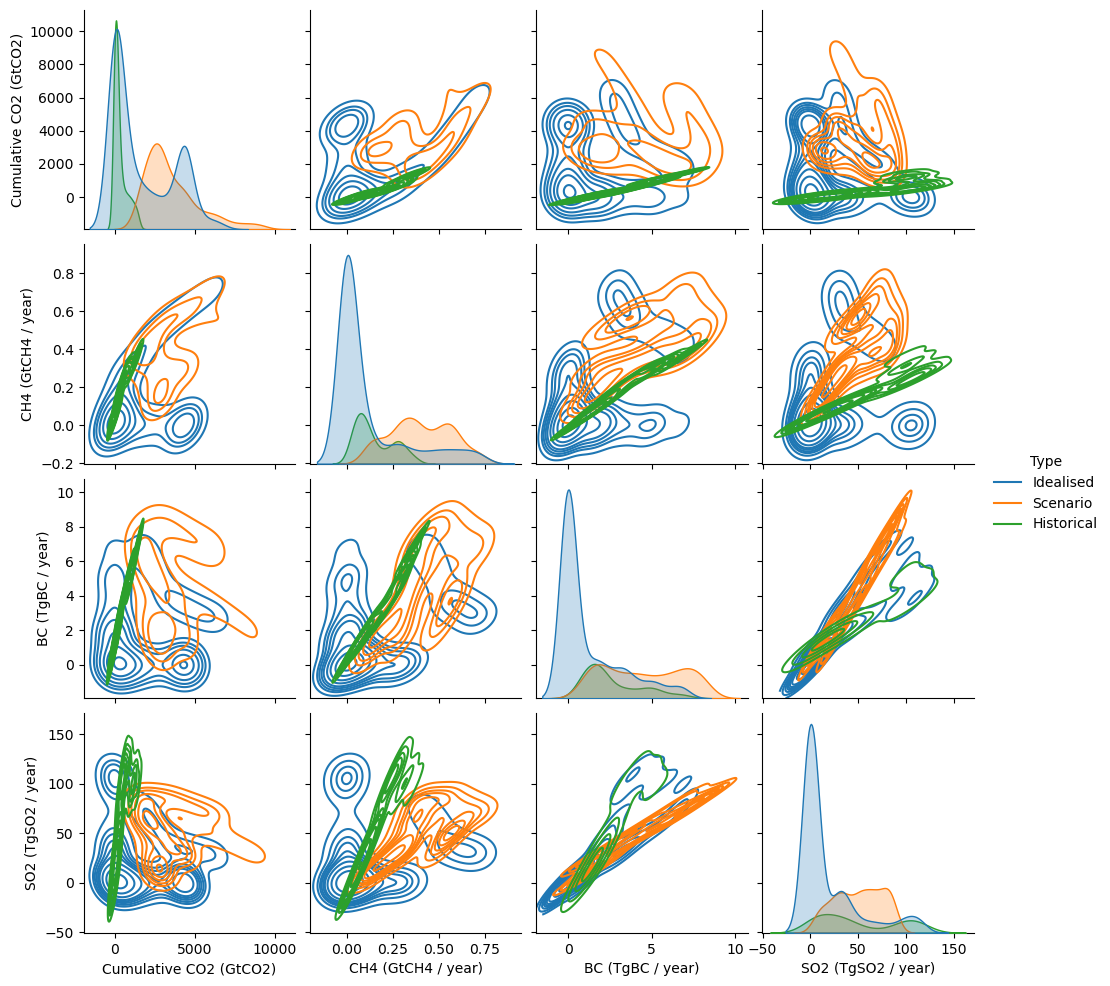

In [21]:
sns.pairplot(plot_df, hue="Type", kind='kde')
# Includes every 5th year from the 4xCo2 experiment since it's roughly 5 times longer than the others

/root/miniconda3/envs/newenv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


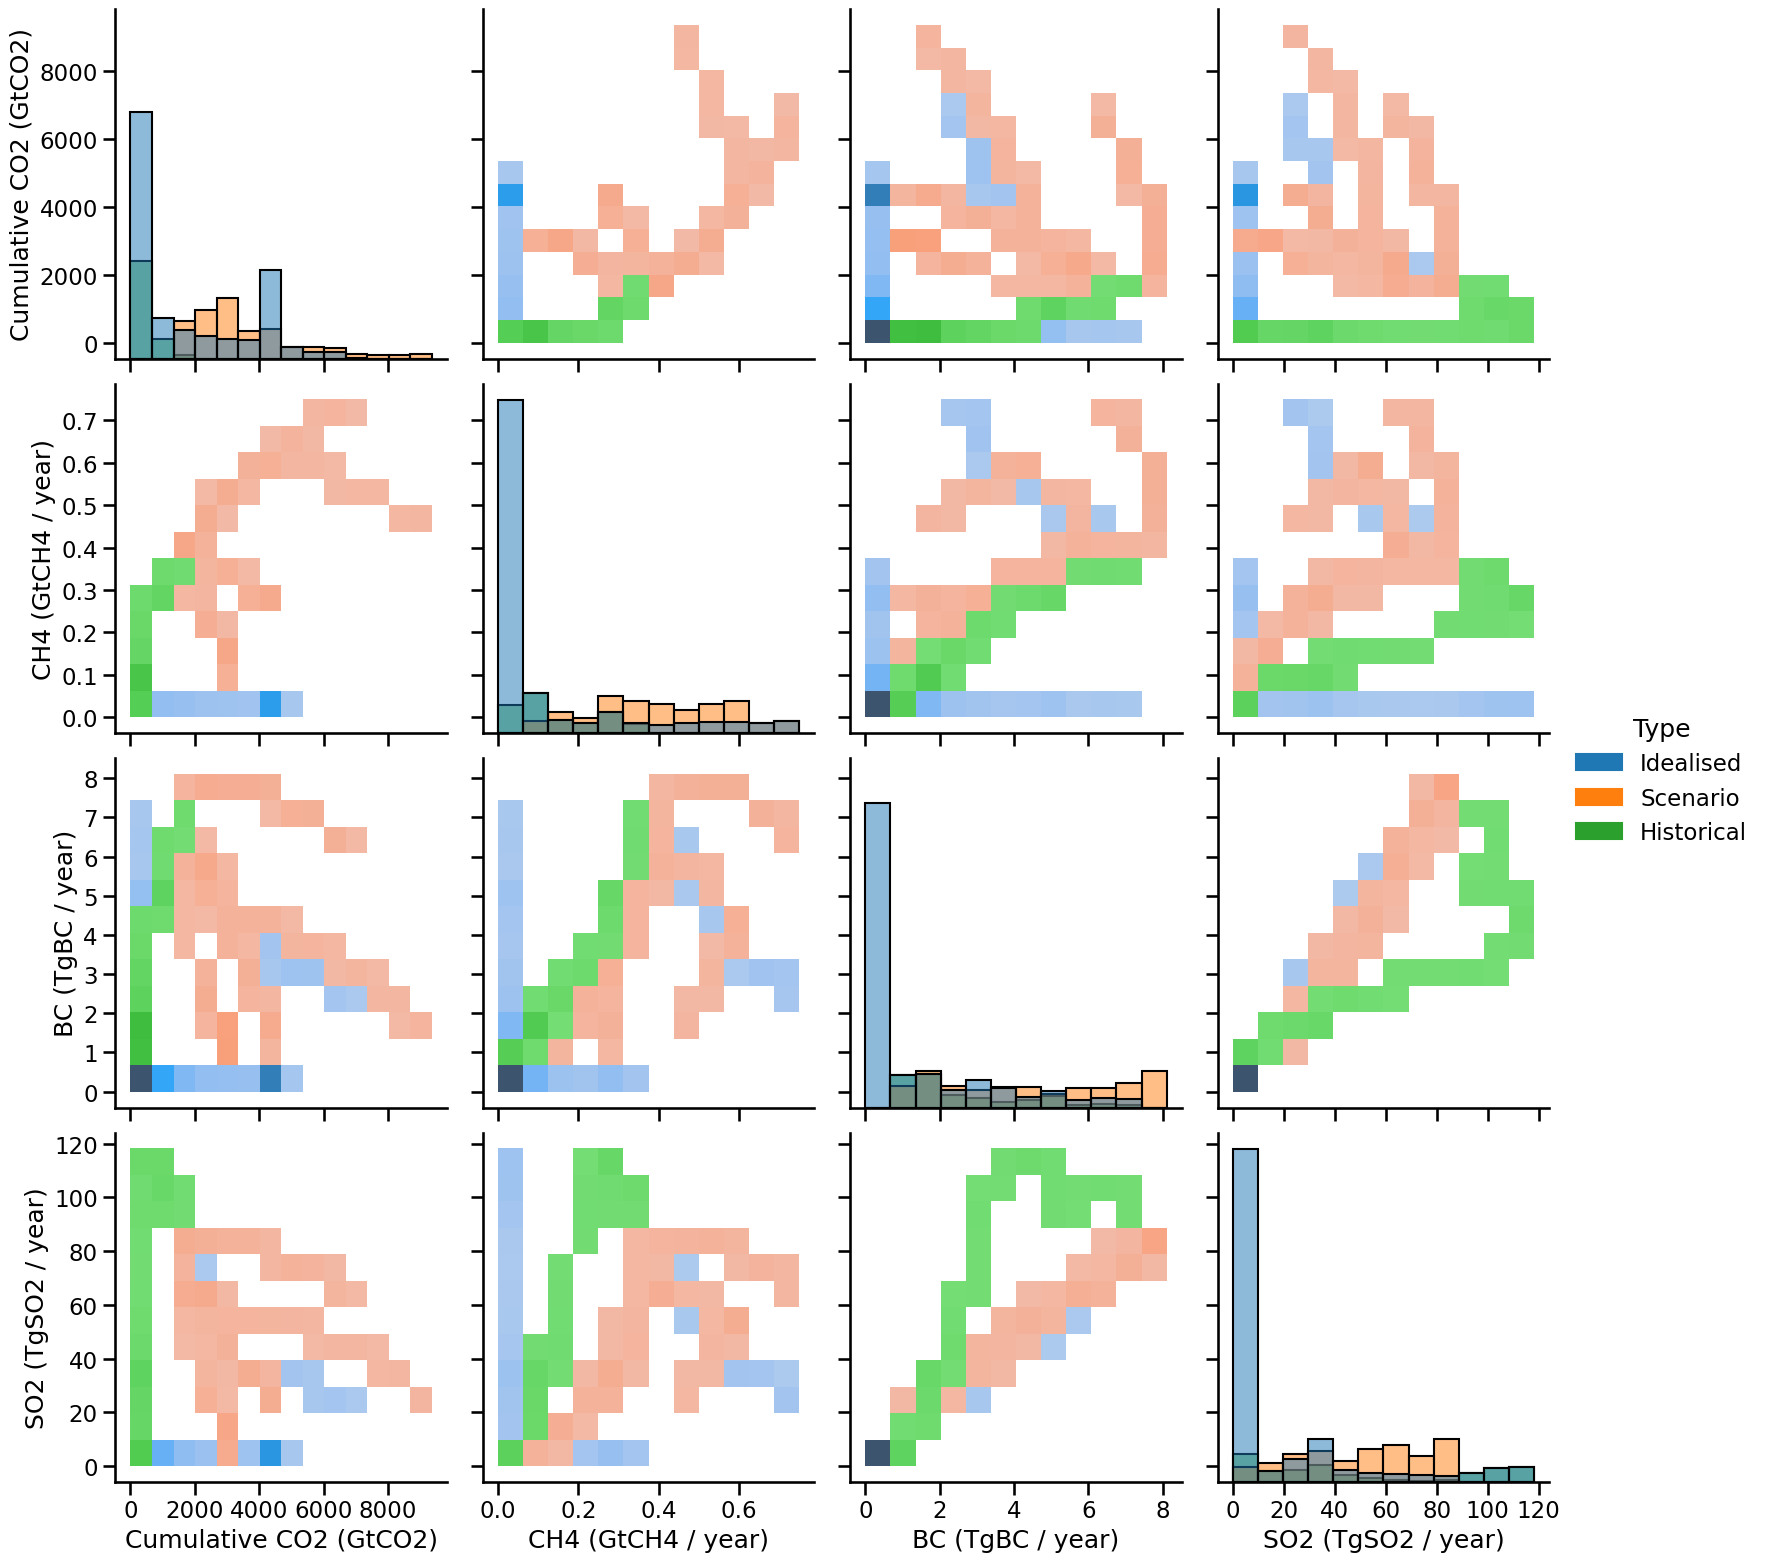

In [22]:
with sns.plotting_context("talk"):

#     fig = plt.figure(figsize=(12,12))

    sns.pairplot(plot_df, hue="Type", kind='hist', height=4)
    
    plt.savefig("Figure_A1.pdf")

In [23]:
# Get one combined historical + ssp585 timeseries for now
X = xr.open_mfdataset([data_path + 'inputs_historical.nc', data_path + 'inputs_ssp245.nc']).compute()

Y = xr.open_dataset(data_path + 'outputs_ssp245.nc')

# Convert the precip values to mm/day
Y["pr"] *= 86400
Y["pr90"] *= 86400

In [24]:
# Leave the projection as PlateCarree for dev then Mollweide for final plots (it's slow!)
proj = ccrs.Mollweide() 
# proj = ccrs.PlateCarree()

# Alternative approaches....:
# Sort the coordinates so that contourf works properly (pcolormesh takes forever in this projection)
# X.coords['longitude'] = (X.coords['longitude'] + 180) % 360 - 180
# X = X.sortby(X.longitude)
# Try adding a cyclic point, but losses the xarray goodness..
# from cartopy.util import add_cyclic_point 

In [25]:
# with sns.plotting_context("talk"):

#     fig = np.log(X["SO2"].sel(time=[1850, 1970, 2020, 2100])).plot.pcolormesh(col='time',col_wrap=2, vmin=-27, vmax=-20,  transform=ccrs.PlateCarree(),
#                                                                               subplot_kws=dict(projection=proj), figsize=(18, 8),
#                                                                               cbar_kwargs=dict(label='Log anthropogenic SO2 emissions (log kg / m2 / s)'))


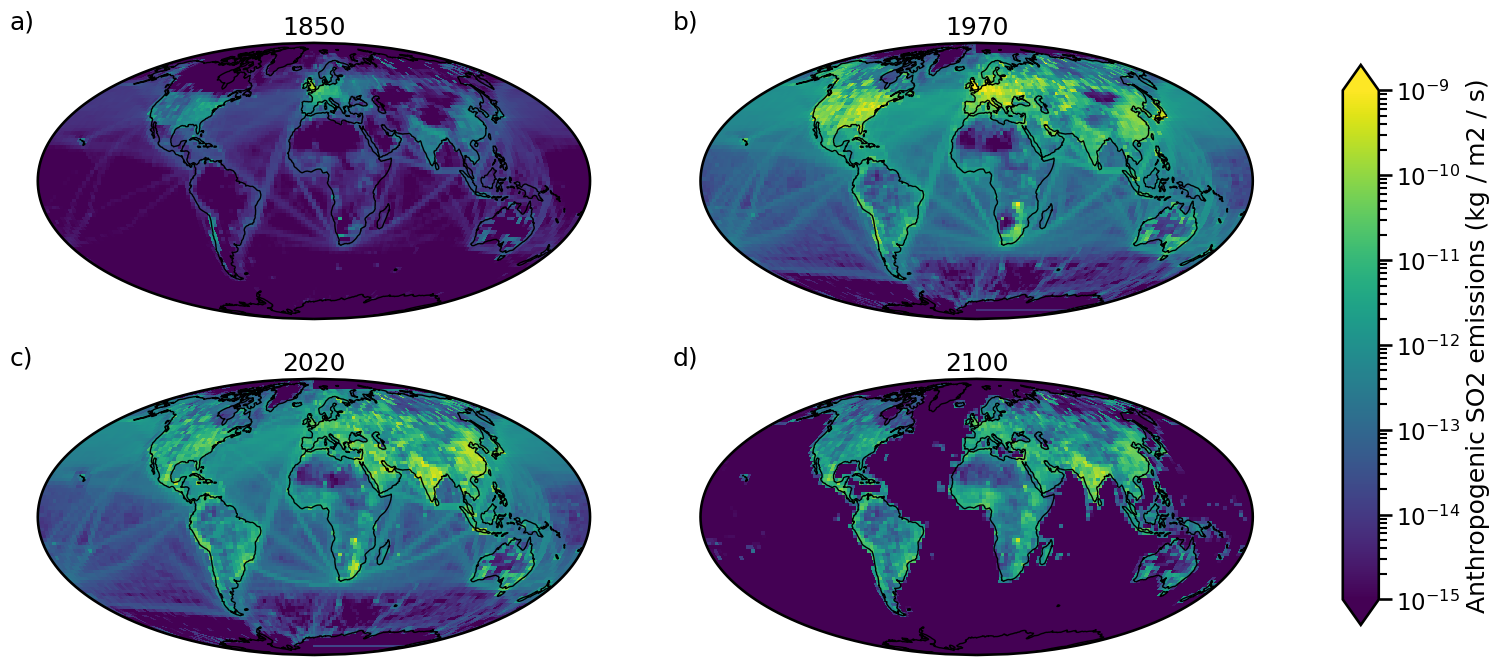

In [26]:
import matplotlib
with sns.plotting_context("talk"):

    norm = matplotlib.colors.LogNorm(1e-17, 1e-10, clip=True)
    norm = matplotlib.colors.LogNorm(1e-15, 1e-9, clip=True)
    fig = plt.figure(figsize=(18, 8))
    plt.subplot(221, projection=proj)
    X["SO2"].sel(time=1850).plot(transform=ccrs.PlateCarree(), add_colorbar=False, norm=norm)
    plt.gca().coastlines()
    plt.gca().set_title('1850')
    add_label('a)')

    plt.subplot(222, projection=proj)
    X["SO2"].sel(time=1970).plot(transform=ccrs.PlateCarree(), add_colorbar=False, norm=norm)
    plt.gca().coastlines()
    plt.gca().set_title('1970')
    add_label('b)')

    plt.subplot(223, projection=proj)
    X["SO2"].sel(time=2020).plot(transform=ccrs.PlateCarree(), add_colorbar=False, norm=norm)
    plt.gca().coastlines()
    plt.gca().set_title('2020')
    add_label('c)')

    plt.subplot(224, projection=proj)
    m=X["SO2"].sel(time=2100).plot(transform=ccrs.PlateCarree(), add_colorbar=False, norm=norm)
    plt.gca().coastlines()
    plt.gca().set_title('2100')
    add_label('d)')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(m, cax=cbar_ax, extend='both')
    cbar.set_label('Anthropogenic SO2 emissions (kg / m2 / s)')
    
    plt.savefig("Figure_2.pdf")

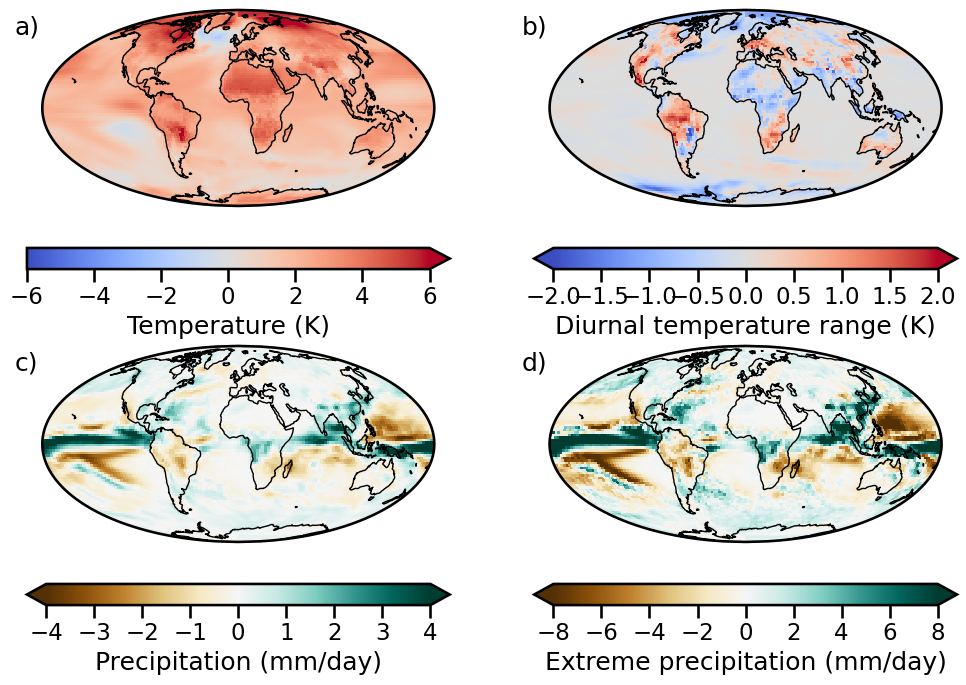

In [27]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=6)

with sns.plotting_context("talk"):

    fig = plt.figure(figsize=(12, 8))
    plt.subplot(221, projection=proj)
    Y["tas"].sel(time=2100, member=1).plot(cmap="coolwarm", vmax=6, transform=ccrs.PlateCarree(), add_labels=False,
                                  cbar_kwargs={"label":"Temperature (K)", "orientation":'horizontal'})
    plt.gca().coastlines()
    add_label('a)', y=0.8)
 
    plt.subplot(222, projection=proj)
    Y["diurnal_temperature_range"].sel(time=2100, member=1).plot(cmap="coolwarm", vmax=2, transform=ccrs.PlateCarree(), add_labels=False,
                                                      cbar_kwargs={"label":"Diurnal temperature range (K)", "orientation":'horizontal'})
    plt.gca().coastlines()
    add_label('b)', y=0.8)

    plt.subplot(223, projection=proj)
    #  Convert precip to mm/day
    (Y["pr"].sel(time=2100, member=1)).plot(cmap="BrBG", transform=ccrs.PlateCarree(), vmin=-4, vmax=4, add_labels=False,
                                 cbar_kwargs={"label":"Precipitation (mm/day)", "orientation":'horizontal'})
    plt.gca().coastlines()
    add_label('c)', y=0.8)

    plt.subplot(224, projection=proj)
    (Y["pr90"].sel(time=2100, member=1)).plot(cmap="BrBG", transform=ccrs.PlateCarree(), vmin=-8, vmax=8, add_labels=False,
                                   cbar_kwargs={"label":"Extreme precipitation (mm/day)", "orientation":'horizontal'})
    plt.gca().coastlines()
    add_label('d)', y=0.8)

    plt.savefig("Figure_3.pdf")

In [32]:
variables = ['tas', 'diurnal_temperature_range', 'pr', 'pr90']
rf_predictions = xr.open_dataset(data_path + "/baseline_models/" + 'outputs_ssp245_prediction_ESEm.nc').swap_dims(sample='time')
rf_predictions = rf_predictions.assign_coords(time=rf_predictions.time+1)  # I don't really know why this is off...
linear_predictions = xr.open_dataset(data_path + 'outputs_ssp245_prediction_pattern2.nc')
nn_predictions = xr.merge([{v: xr.open_dataarray(data_path + "/baseline_models/" + "outputs_ssp245_predict_{}.nc".format(v))} for v in variables])
gp_predictions = xr.merge([{v: xr.open_dataarray(data_path + "/baseline_models/" + "climatebench-gp-posterior-mean-{}-test-2019-2100.nc".format(v))} for v in variables])

FileNotFoundError: [Errno 2] No such file or directory: '/root/ClimateBench/baseline_models/outputs_ssp245_predict_tas.nc'

In [16]:
# Convert the precip values to mm/day
nn_predictions["pr"] *= 86400
nn_predictions["pr90"] *= 86400

In [17]:
models = [linear_predictions, rf_predictions, nn_predictions, gp_predictions, Y.mean('member')]
model_labels = ['Pattern Scaling', 'Random Forest', "Neural Network", 'Gaussian Process', 'NorESM2']
labels = ["Temperature (K)", "Diurnal temperature range (K)", "Precipitation (mm/day)", "Extreme precipitation (mm/day)"]
kwargs = [dict(cmap="coolwarm", vmax=6), dict(cmap="coolwarm", vmin=-2, vmax=2), dict(cmap="BrBG", vmin=-4, vmax=4), dict(cmap="BrBG", vmin=-8, vmax=8)]

In [18]:
def ttest_rel_from_stats(diff_mean, diff_std, diff_num):
    """
    Calculates the T-test for the means of *two independent* samples of scores.

    This is a two-sided test for the null hypothesis that 2 independent samples
    have identical average (expected) values. This test assumes that the
    populations have identical variances by default.

    It is deliberately similar in interface to the other scipy.stats.ttest_... routines

    See e.g. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind_from_stats.html
    and pg. 140 in Statistical methods in Atmos Sciences
    
    :param diff: The mean difference, x_d (|x1 - x1| == |x1| - |x2|)
    :param diff_std: The standard deviation in the difference, s_d (sqrt(Var[x_d]))
    :param diff_num: The number of points, n (n == n1 == n2)
    :return float, float: t-statistic, p-value
    """
    from scipy.stats import distributions

    z = diff_mean / np.sqrt(diff_std ** 2 / diff_num)
    # use np.abs to get upper tail, then multiply by two as this is a two-tailed test
    p = distributions.t.sf(np.abs(z), diff_num - 1) * 2
    return z, p

p_level = 0.05

[[<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]]


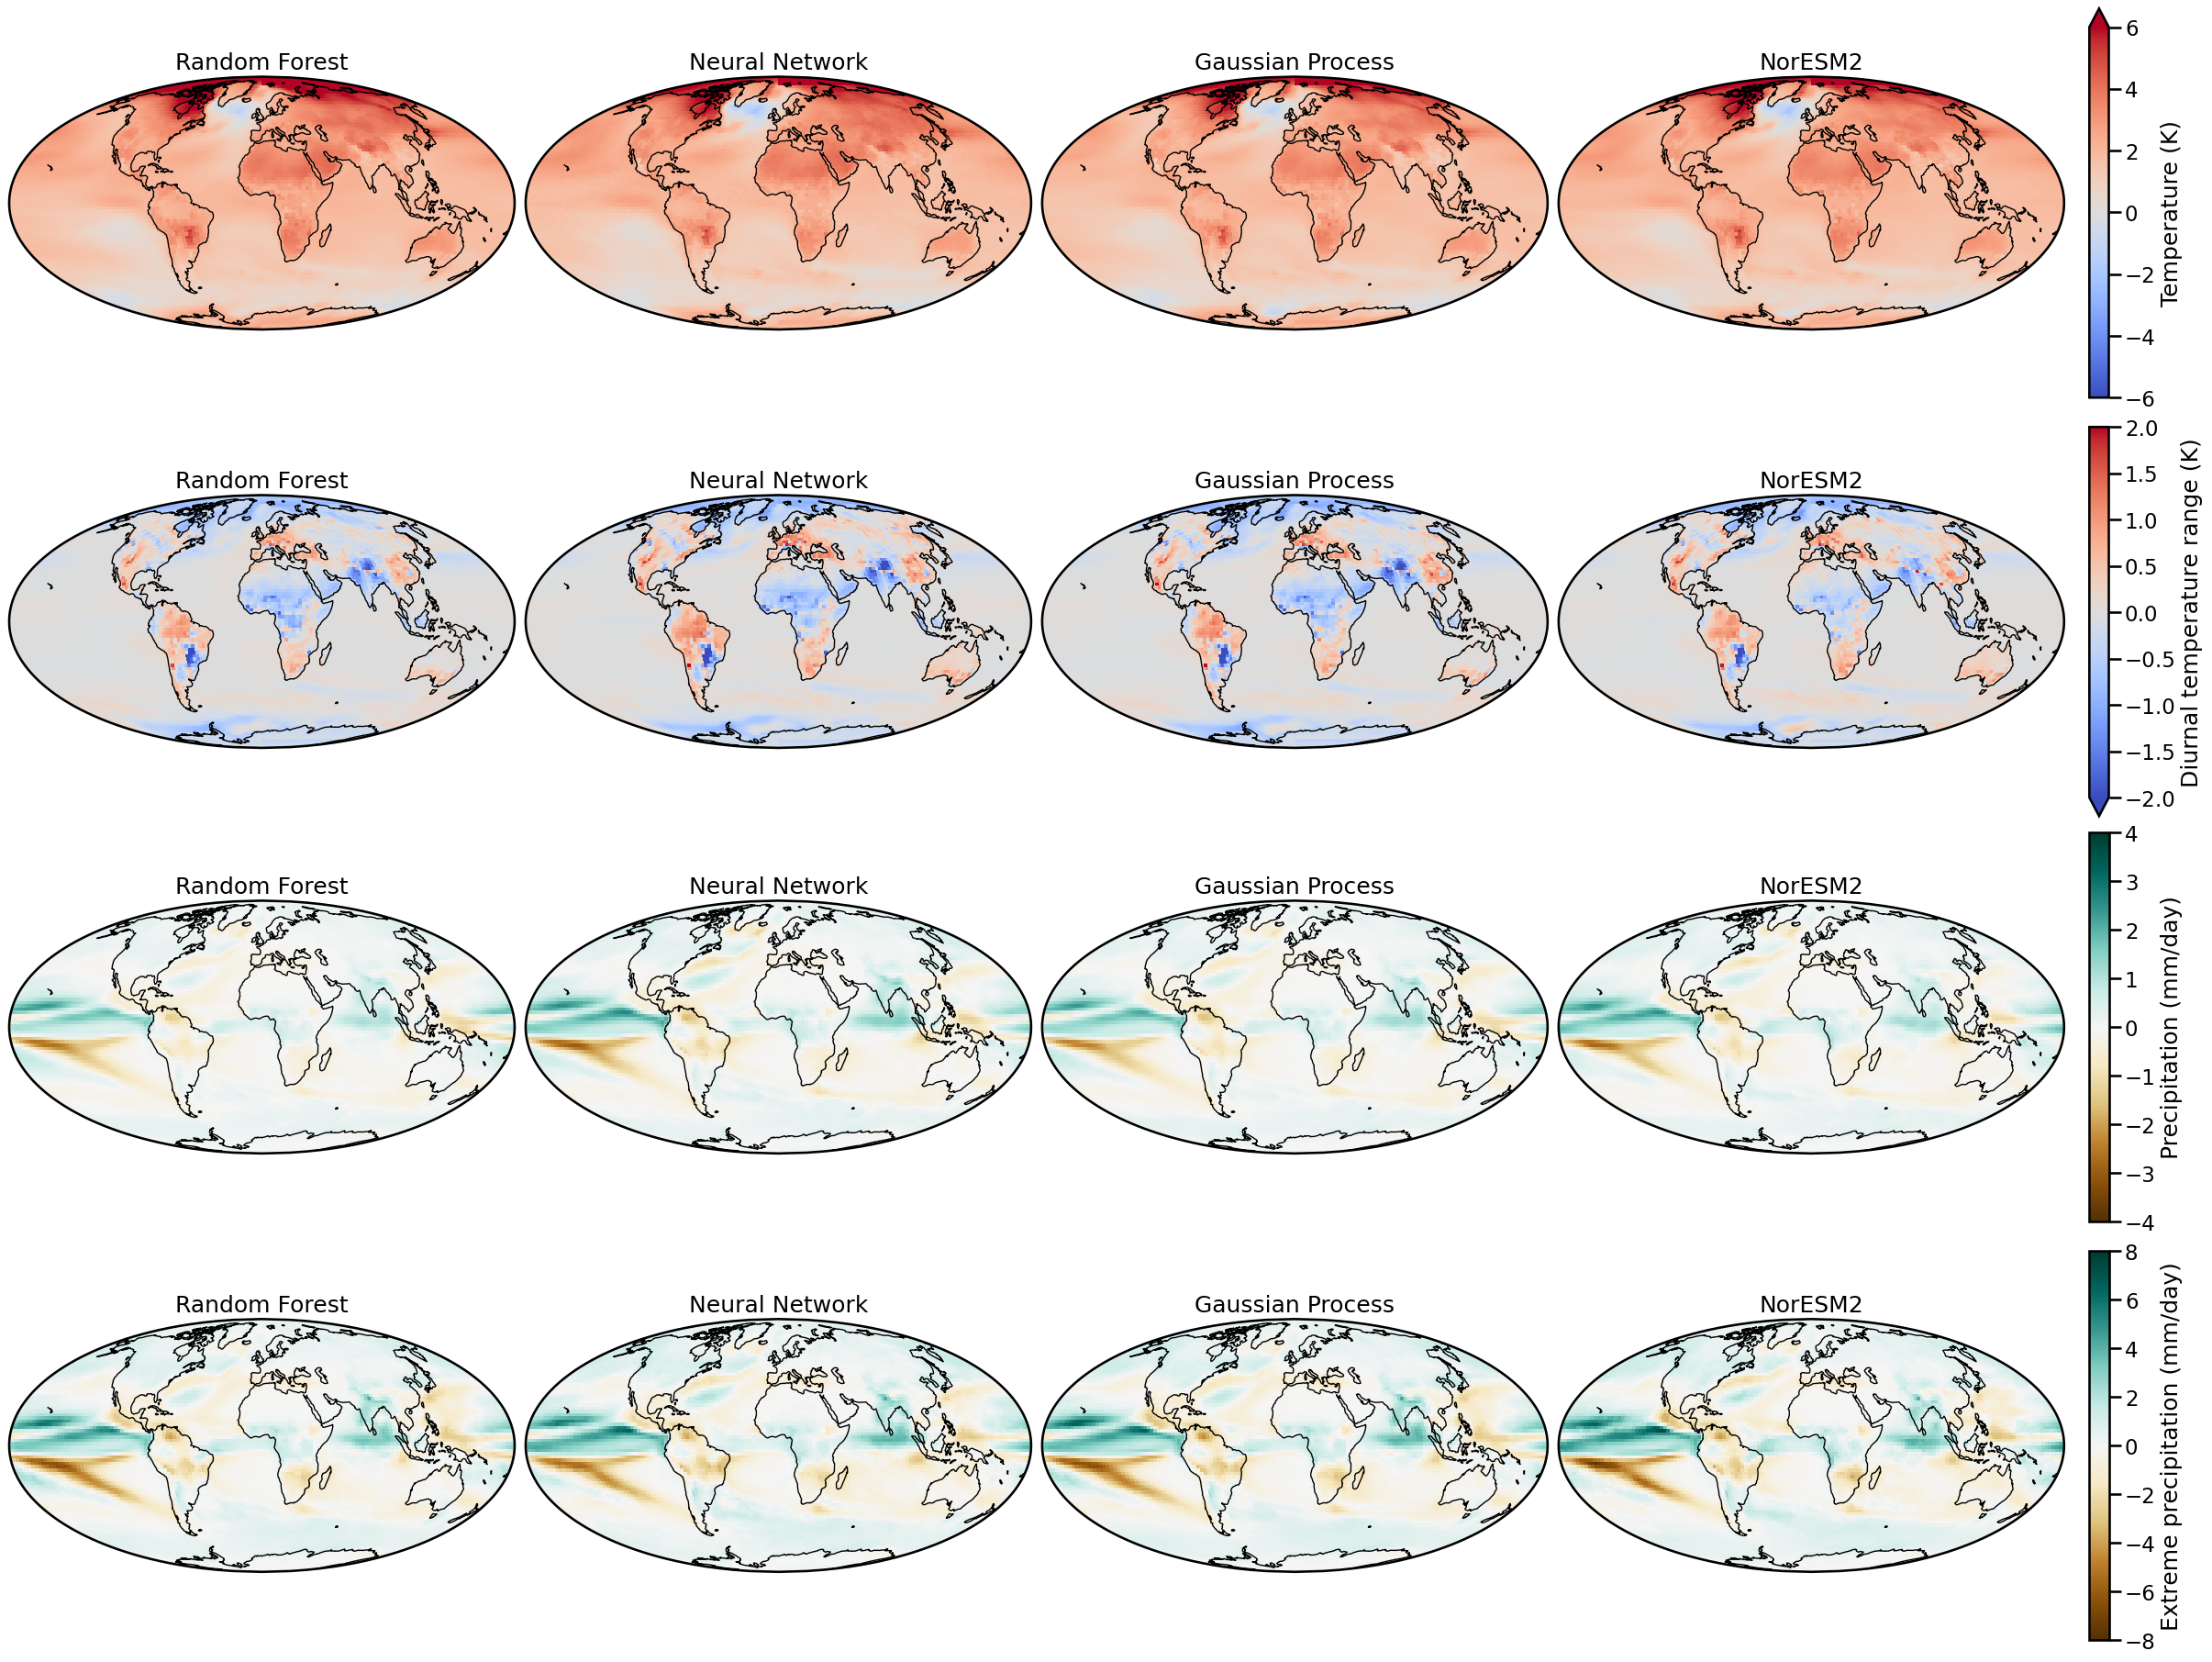

In [19]:
with sns.plotting_context("talk"):

#     fig = plt.figure()
    fig, axes = plt.subplots(4, 4, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
    print(axes)
    for model_axes, var, label, kws in zip(axes, variables, labels, kwargs):
        for ax, model, model_label in zip(model_axes, models[1:], model_labels[1:]):
#             if label == 'Temperature (K)':
            ax.set_title(model_label)
            if model_label == 'NorESM2':
                model[var].sel(time=slice(2080, 2100)).mean(['time']).plot(ax=ax, add_labels=False, transform=ccrs.PlateCarree(), cbar_kwargs={"label":label, "orientation":'vertical'}, **kws)
            else: 
                model[var].sel(time=slice(2080, 2100)).mean('time').plot(ax=ax, add_labels=False, transform=ccrs.PlateCarree(), add_colorbar=False, **kws)
            ax.coastlines()
                
    plt.savefig("Figure_A2.pdf")

[[<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]]


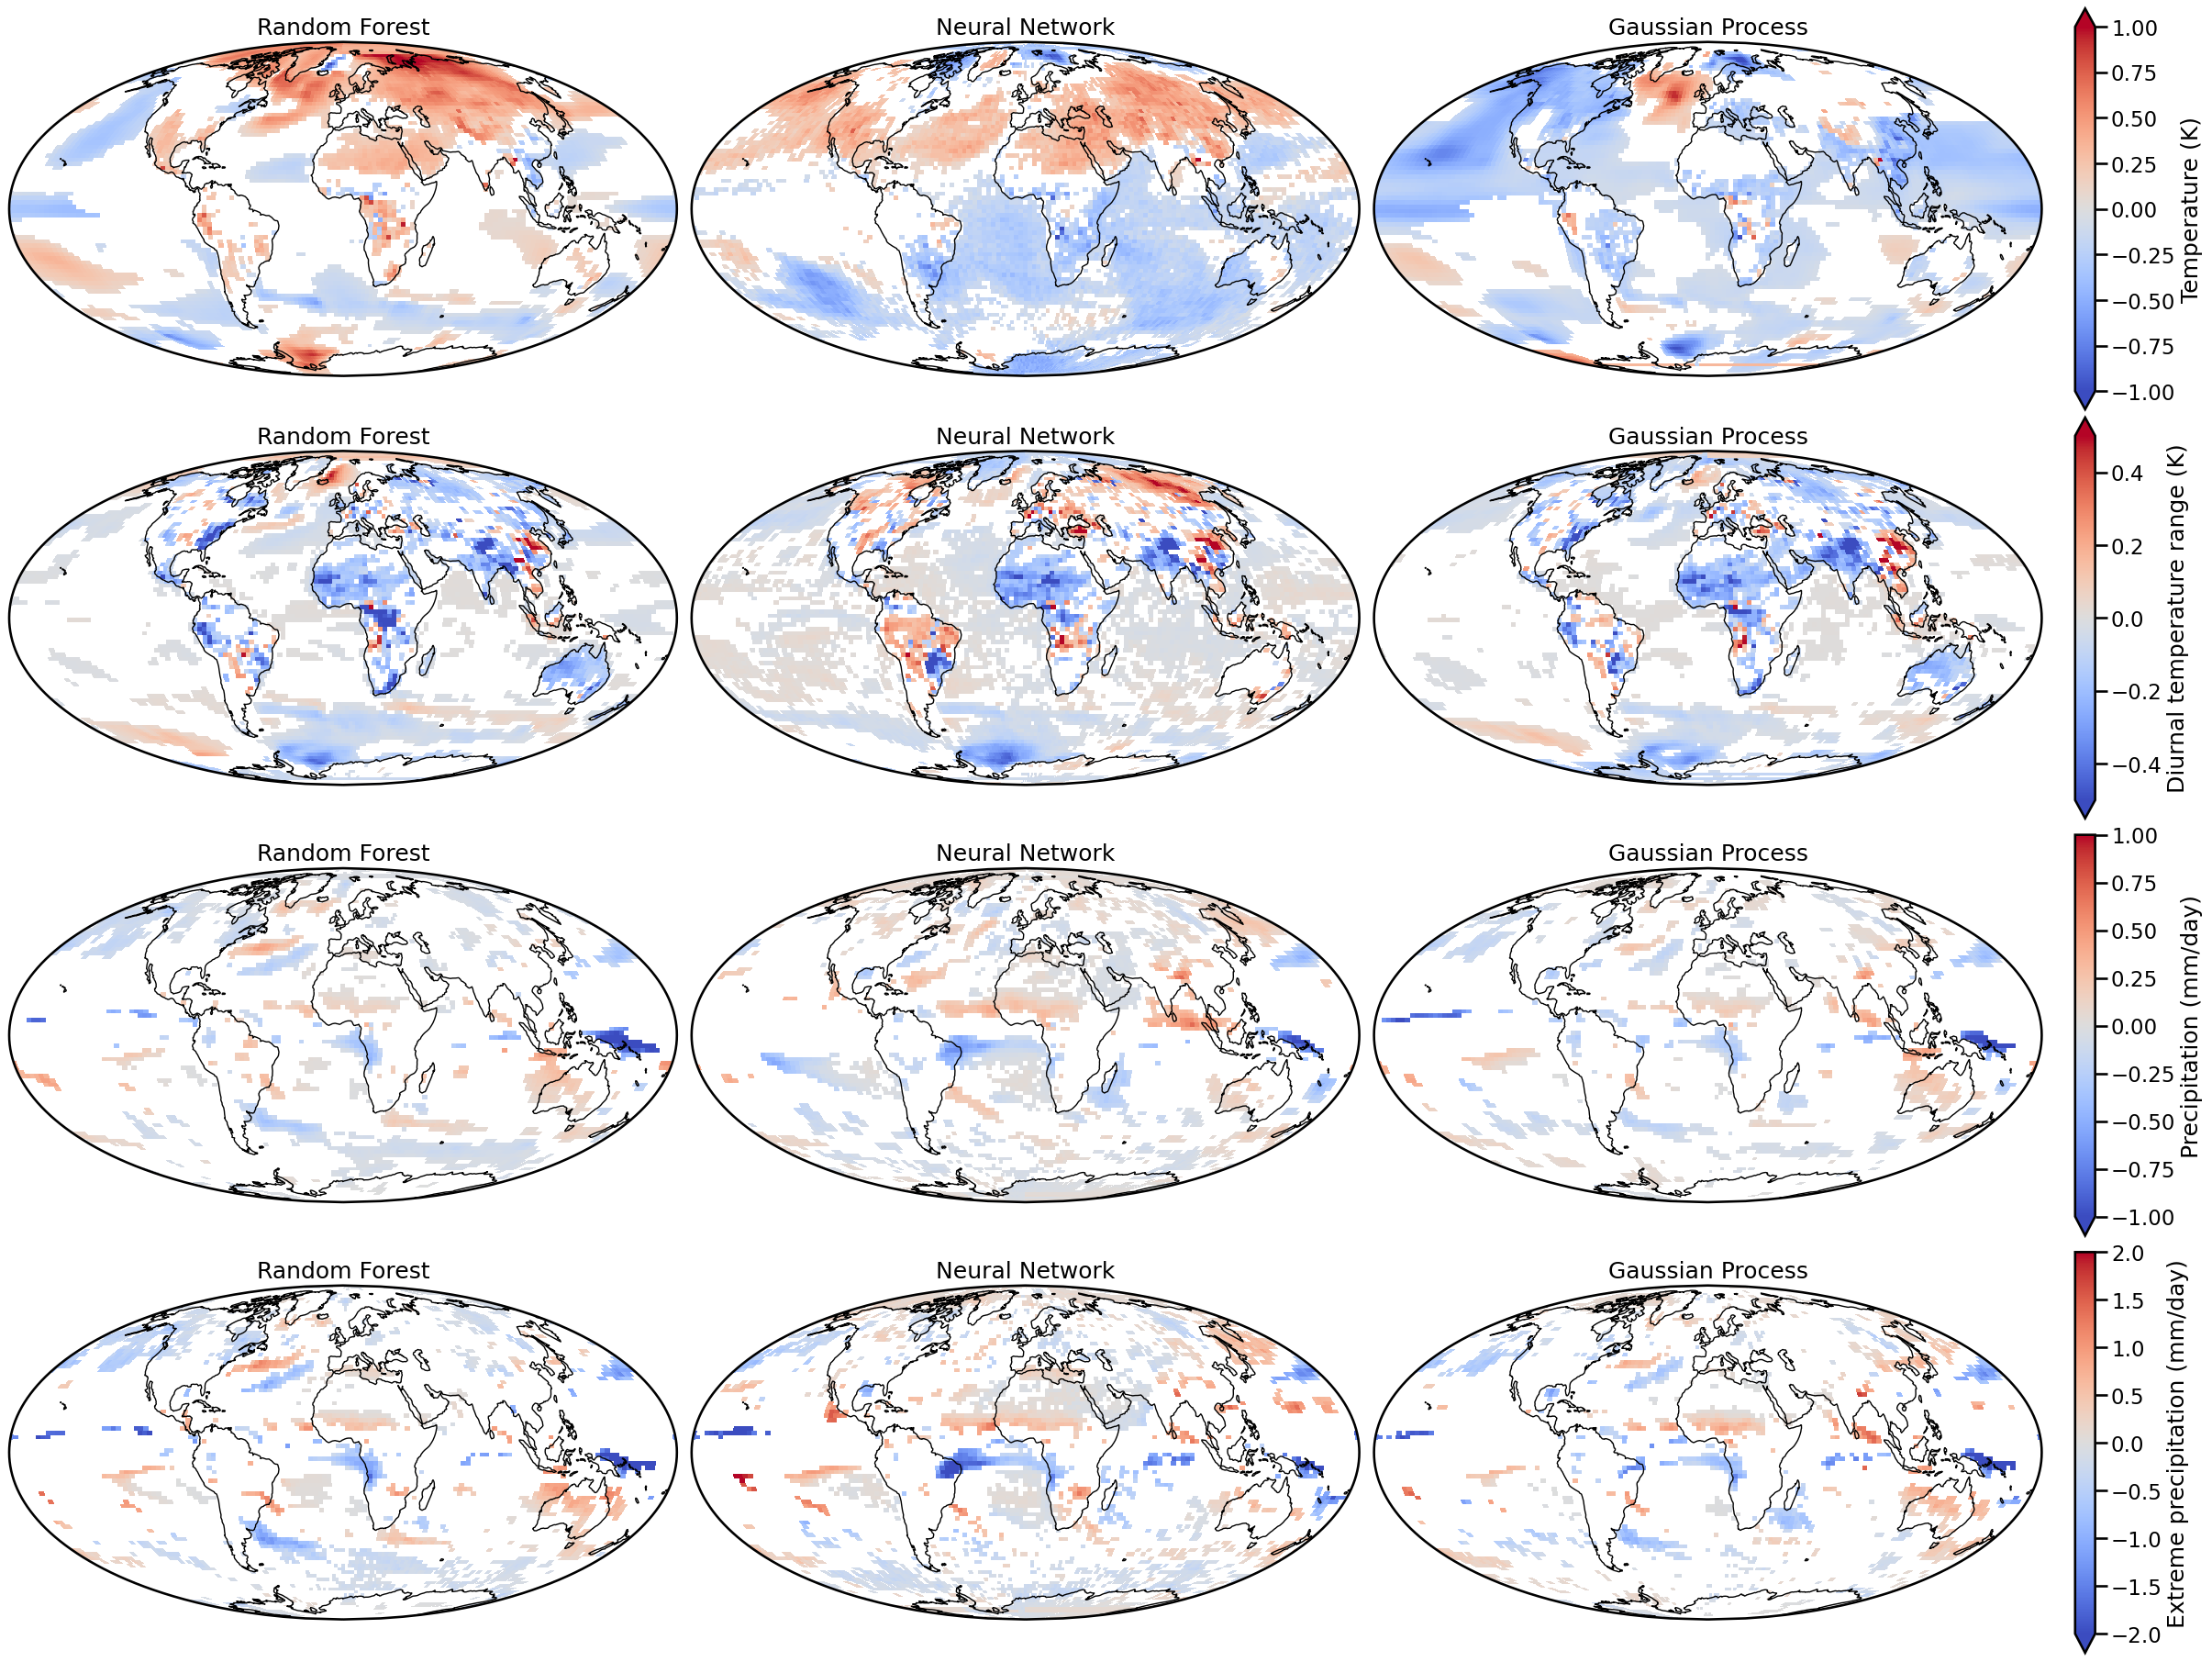

In [20]:
# proj = ccrs.PlateCarree()
kwargs = [dict(vmin=-1, vmax=1), dict(vmin=-0.5, vmax=0.5), dict(vmin=-1, vmax=1), dict(vmin=-2, vmax=2)]


with sns.plotting_context("talk"):

#     fig = plt.figure()
    fig, axes = plt.subplots(4, 3, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
    print(axes)
    for model_axes, var, label, kws in zip(axes, variables, labels, kwargs):
        for ax, model, model_label in zip(model_axes, models[1:-1], model_labels[1:-1]):
#             if label == 'Temperature (K)':
            ax.set_title(model_label)
#             print(model_label, model)
            diff = (model[var]-models[-1][var]).sel(time=slice(2080, 2100)) # /models[-1][var]
            mean_diff = diff.mean('time')
            _, p = ttest_rel_from_stats(mean_diff, diff.std('time'), diff.count('time'))
            if model_label == 'Gaussian Process':
                mean_diff.where(p < p_level).plot(cmap="coolwarm", ax=ax, add_labels=False, transform=ccrs.PlateCarree(), cbar_kwargs={"label":label, "orientation":'vertical'}, **kws)
            else:
                mean_diff.where(p < p_level).plot(cmap="coolwarm", ax=ax, add_labels=False, transform=ccrs.PlateCarree(), add_colorbar=False, **kws)
            
            ax.coastlines()
    
    plt.savefig("Figure_4.pdf")

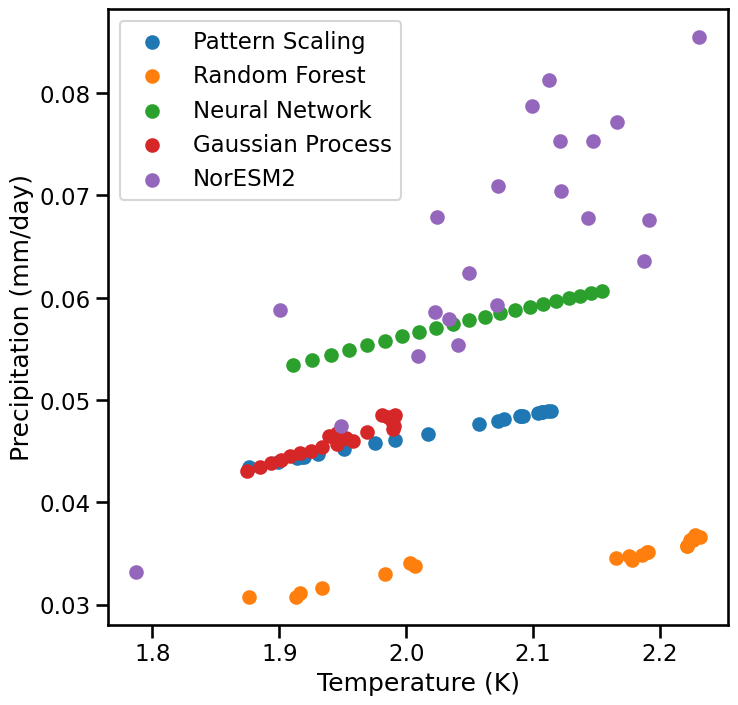

In [21]:
# models = [rf_predictions, nn_predictions, gp_predictions, Y.mean('member')]
# model_labels = ['Random Forest', "Neural Network", 'Gaussian Process', 'NorESM2']

def global_mean(ds):
    if 'lat' not in ds.coords:
        ds_ = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    else:
        ds_ = ds
    weights = np.cos(np.deg2rad(ds_.lat))
    return ds_.weighted(weights).mean(['lat', 'lon'])

with sns.plotting_context("talk"):

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for model, model_label in zip(models, model_labels):
        ax.scatter(global_mean(model['tas'].sel(time=slice(2080, 2100))), global_mean(model['pr'].sel(time=slice(2080, 2100))), label=model_label)
    plt.setp(plt.gca(), xlabel="Temperature (K)", ylabel="Precipitation (mm/day)")
    plt.legend()
                

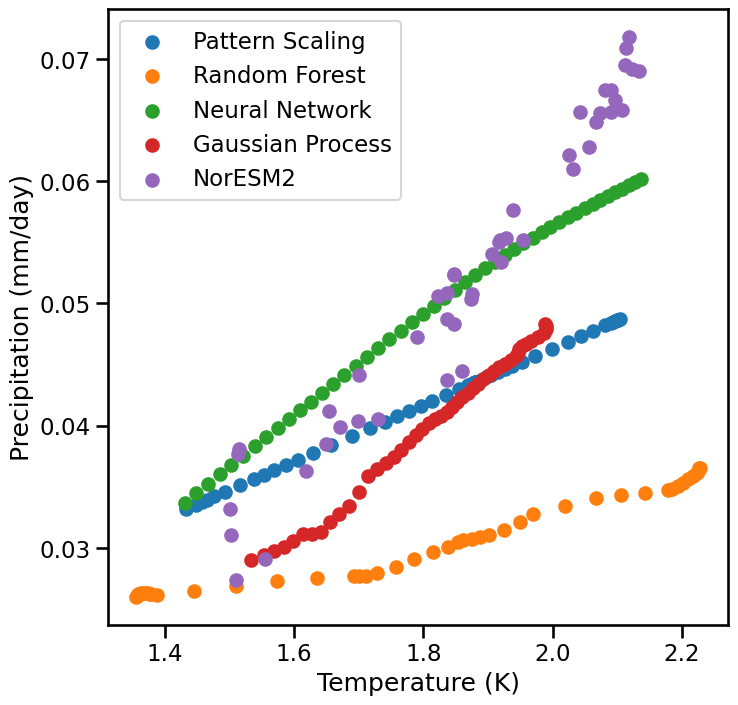

In [22]:
with sns.plotting_context("talk"):

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for model, model_label in zip(models, model_labels):
        ax.scatter(global_mean(model['tas'].sel(time=slice(2050, 2100))).rolling(time=5, center=True).mean(), global_mean(model['pr'].sel(time=slice(2050, 2100))).rolling(time=5, center=True).mean(), label=model_label)
    plt.setp(plt.gca(), xlabel="Temperature (K)", ylabel="Precipitation (mm/day)")
    plt.legend()

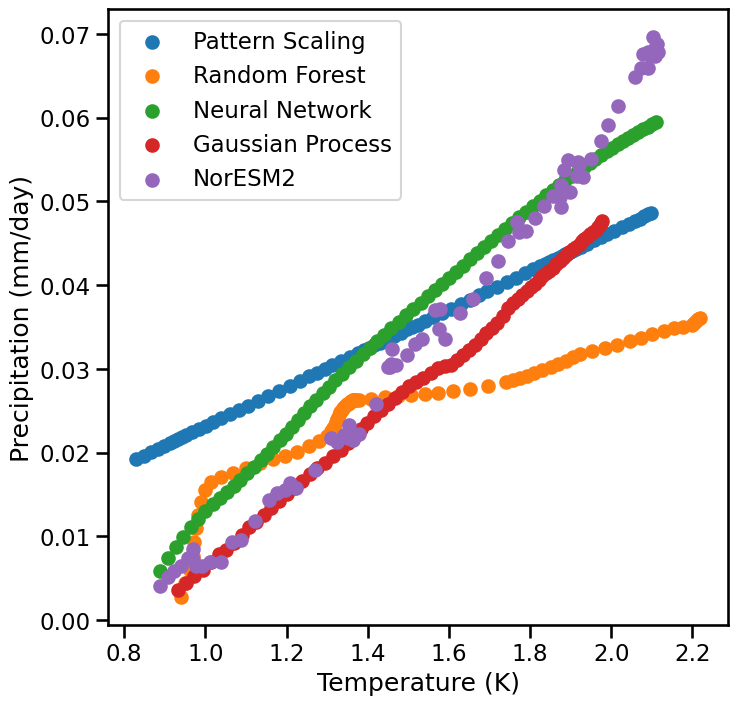

In [23]:
with sns.plotting_context("talk"):

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for model, model_label in zip(models, model_labels):
        ax.scatter(global_mean(model['tas']).rolling(time=10, center=True).mean(), global_mean(model['pr']).rolling(time=10, center=True).mean(), label=model_label)
    plt.setp(plt.gca(), xlabel="Temperature (K)", ylabel="Precipitation (mm/day)")
    plt.legend()

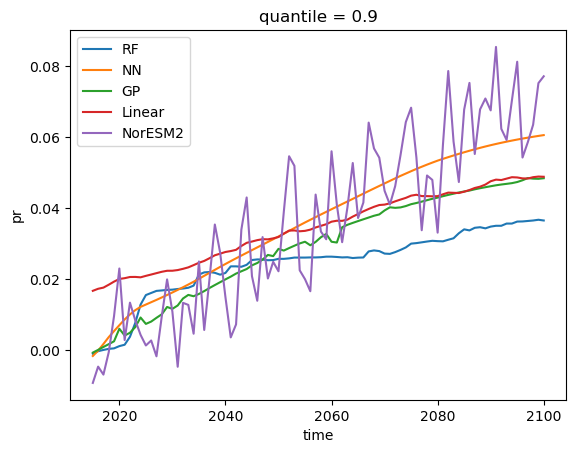

In [24]:
global_mean(rf_predictions['pr']).plot(label='RF')
global_mean(nn_predictions['pr']).plot(label='NN')
global_mean(gp_predictions['pr']).plot(label='GP')
global_mean(linear_predictions['pr']).plot(label='Linear')
global_mean(Y['pr'].mean('member')).plot(label='NorESM2')
plt.legend()

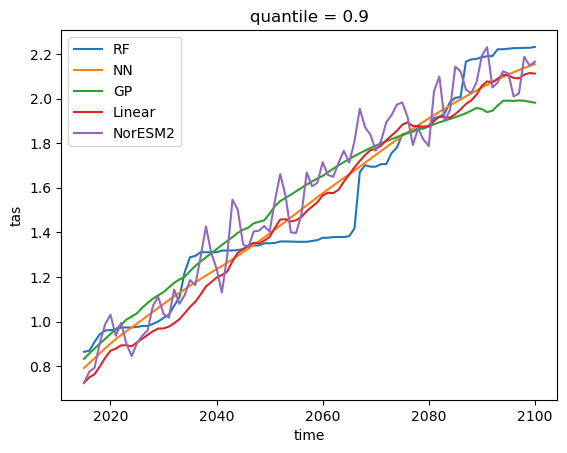

In [25]:
global_mean(rf_predictions['tas']).plot(label='RF')
global_mean(nn_predictions['tas']).plot(label='NN')
global_mean(gp_predictions['tas']).plot(label='GP')
global_mean(linear_predictions['tas']).plot(label='Linear')
global_mean(Y['tas'].mean('member')).plot(label='NorESM2')
plt.legend()

Energetic slope: [2.] intercept: -0.9999999999999996
Pattern Scaling slope: [0.99185492] intercept: 2.220446049250313e-16
Random Forest slope: [0.84434672] intercept: -0.23971390692089312
Neural Network slope: [1.85563674] intercept: -1.2866262926437217
Gaussian Process slope: [1.79210291] intercept: -1.5192503005945222
NorESM2 slope: [2.34465709] intercept: -2.096307559354343


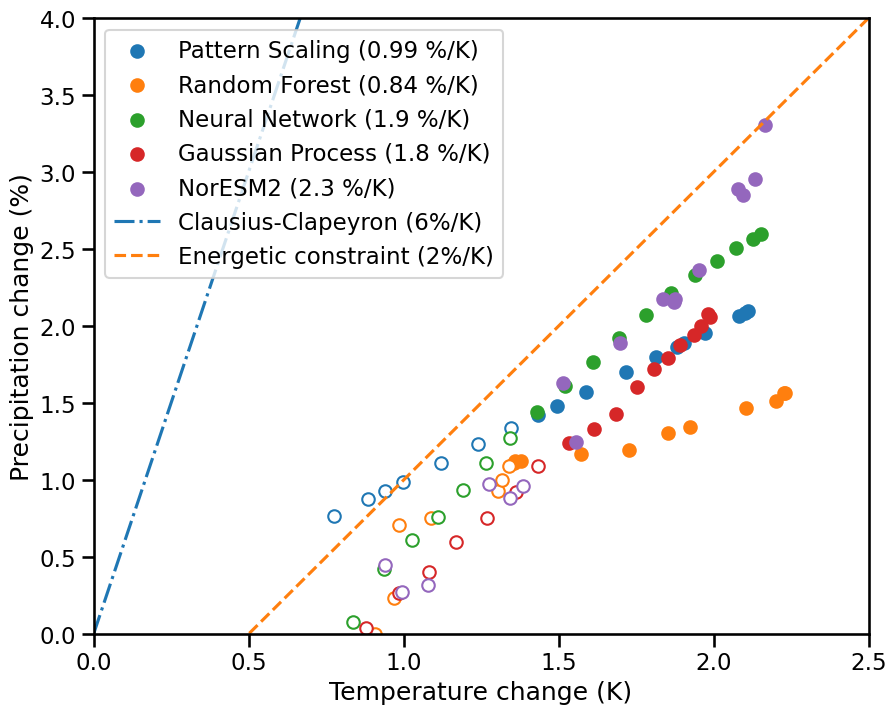

In [26]:
from sklearn.linear_model import LinearRegression

baseline_precip = 2.33511687 # From piControl

with sns.plotting_context("talk"):
    
    x = np.linspace(0, 2.5, 100)
    
    m=LinearRegression().fit(x[:, np.newaxis], x*2-1)
    print("{} slope: {} intercept: {}".format('Energetic', m.coef_, m.intercept_))

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    for model, model_label in zip(models, model_labels):
        smooth = global_mean(model).rolling(time=10).mean().dropna('time')
        smooth = global_mean(model).coarsen(time=5, boundary='pad').mean().dropna('time')
        x_, y_ = smooth['tas'], smooth['pr']/baseline_precip*100
        m=LinearRegression().fit(x_.data[:, np.newaxis], y_)

        s=ax.scatter(x_.sel(time=slice(2050, None)), y_.sel(time=slice(2050, None)), label="{} ({:0.2} %/K)".format(model_label, m.coef_[0]))
        ax.scatter(x_.sel(time=slice(None, 2050)), y_.sel(time=slice(None, 2050)), facecolor='w', edgecolor=s.get_facecolor())
        print("{} slope: {} intercept: {}".format(model_label, m.coef_, m.intercept_))
    
    plt.plot(x, x*6, label="Clausius-Clapeyron (6%/K)", ls='-.')
    plt.plot(x, x*2-1, label="Energetic constraint (2%/K)", ls='--')
    
    plt.setp(plt.gca(), xlabel="Temperature change (K)", ylabel="Precipitation change (%)", xlim=[0, 2.5], ylim=[0, 4])
    plt.legend(loc='upper left')
    
    plt.savefig("Figure_6.pdf")

In [27]:
from xskillscore import rmse, pearson_r, spearman_r, r2, smape, mae, me, mse

weights = np.cos(np.deg2rad(Y['tas'].lat)).expand_dims(lon=144).assign_coords(lon=Y.lon)

In [28]:

R2E = pd.DataFrame({
    label: {variable: rmse( global_mean(Y.mean('member')[variable].sel(time=slice(2080, None))), 
                                global_mean(model[variable].sel(time=slice(2080, None)))).data/ np.abs(global_mean(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data) for variable in variables} 
#                                 global_mean(model[variable].sel(time=slice(2080, None)))).data for variable in variables} 
                           for label, model in zip(model_labels[:-1], models[:-1])
})
R2E.T.round(3).style.highlight_min(subset=slice("Random Forest", None), axis = 0, props='font-weight: bold').format("{:.4f}")

In [29]:
NRMSE = pd.DataFrame({
    label: {variable: rmse(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time'), 
                               model[variable].sel(time=slice(2080, None)).mean('time'), weights=weights).data/ np.abs(global_mean(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data) for variable in variables} 
    for label, model in zip(model_labels[:-1], models[:-1])
})
NRMSE.T.round(3).style.highlight_min(subset=slice("Random Forest", None), axis = 0, props='font-weight: bold').format("{:.4f}")

In [30]:
(NRMSE+5*R2E).T.round(3).style.highlight_min(subset=slice("Random Forest", None), axis = 0, props='font-weight: bold').format("{:.4f}")

In [31]:
combined_df = pd.concat([NRMSE, R2E, NRMSE+5*R2E], keys=['Spatial', 'Global', 'Total'])[model_labels[3::-1]].T.swaplevel(axis=1)[variables]

In [32]:
combined_df.style.highlight_min(subset=slice(None, "Random Forest"), axis = 0, props='font-weight: bold').format("{:.3f}")

In [33]:

R2E = pd.DataFrame({
    "Variability": {variable: global_mean(Y[variable].sel(time=slice(2080, None))).std().data / np.abs(global_mean(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data) for variable in variables} 
})

NRMSE = pd.DataFrame({
    "Variability": {variable: global_mean(Y[variable].sel(time=slice(2080, None)).mean('time').std('member')).data/ np.abs(global_mean(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data) for variable in variables}
})

variability_df = pd.concat([NRMSE, R2E, NRMSE+5*R2E], keys=['Spatial', 'Global', 'Total']).T.swaplevel(axis=1)[variables]


In [34]:
CMIP6_df = variability_df.copy().rename(dict(Variability='CMIP6'))
CMIP6_df.T['CMIP6'] = np.NaN

In [35]:
all_df = pd.concat([combined_df, variability_df, CMIP6_df])
all_df.style.highlight_min(subset=slice(None, "Random Forest"), axis = 0, props='font-weight: bold').format("{:.3f}")

# Idealised experiment results

In [36]:
# Get one combined historical + ssp585 timeseries for now
alt_Y = xr.open_dataset(data_path + 'outputs_ssp245-aer.nc')

# Convert the precip values to mm/day
alt_Y["pr"] *= 86400
alt_Y["pr90"] *= 86400

In [37]:
rf_predictions = xr.open_dataset(data_path + "/revisions_2/" + 'outputs_ssp245_prediction_ESEm-aer.nc').swap_dims(sample='time')
rf_predictions = rf_predictions.assign_coords(time=rf_predictions.time+1)  # I don't really know why this is off...

linear_predictions = xr.open_dataset(data_path + '/revisions_2/'+'outputs_ssp245_prediction_pattern2-aer.nc')
nn_predictions = xr.merge([{v: xr.open_dataarray(data_path +'/revisions_2/'+ "outputs_ssp245_predict_{}-aer.nc".format(v))} for v in variables])
gp_predictions = xr.merge([{v: xr.open_dataarray(data_path + '/revisions_2/'+"climatebench-gp-posterior-mean-{}-test-aer-2019-2100.nc".format(v))} for v in variables])

In [38]:
# Convert the precip values to mm/day
nn_predictions["pr"] *= 86400
nn_predictions["pr90"] *= 86400

In [39]:
models = [linear_predictions, rf_predictions, nn_predictions, gp_predictions, alt_Y.mean('member')]
model_labels = ['Linear', 'Random Forest', "Neural Network", 'Gaussian Process', 'NorESM2']
labels = ["Temperature (K)", "Diurnal temperature range (K)", "Precipitation (mm/day)", "Extreme precipitation (mm/day)"]
kwargs = [dict(cmap="coolwarm", vmax=6), dict(cmap="coolwarm", vmin=-2, vmax=2), dict(cmap="BrBG", vmin=-4, vmax=4), dict(cmap="BrBG", vmin=-8, vmax=8)]

In [40]:
# with sns.plotting_context("talk"):

# #     fig = plt.figure()
#     fig, axes = plt.subplots(4, 4, subplot_kw=dict(projection=proj), figsize=(30, 18), constrained_layout=True)
#     print(axes)
#     for model_axes, var, label, kws in zip(axes, variables, labels, kwargs):
#         for ax, model, model_label in zip(model_axes, models[1:], model_labels[1:]):
# #             if label == 'Temperature (K)':
#             ax.set_title(model_label)
#             if model_label == 'NorESM2':
#                 model[var].sel(time=slice(2080, 2100)).mean(['time']).plot(ax=ax, add_labels=False, transform=ccrs.PlateCarree(), cbar_kwargs={"label":label, "orientation":'vertical'}, **kws)
#             else: 
#                 model[var].sel(time=slice(2080, 2100)).mean('time').plot(ax=ax, add_labels=False, transform=ccrs.PlateCarree(), add_colorbar=False, **kws)
#             ax.coastlines()
                

[[<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]]


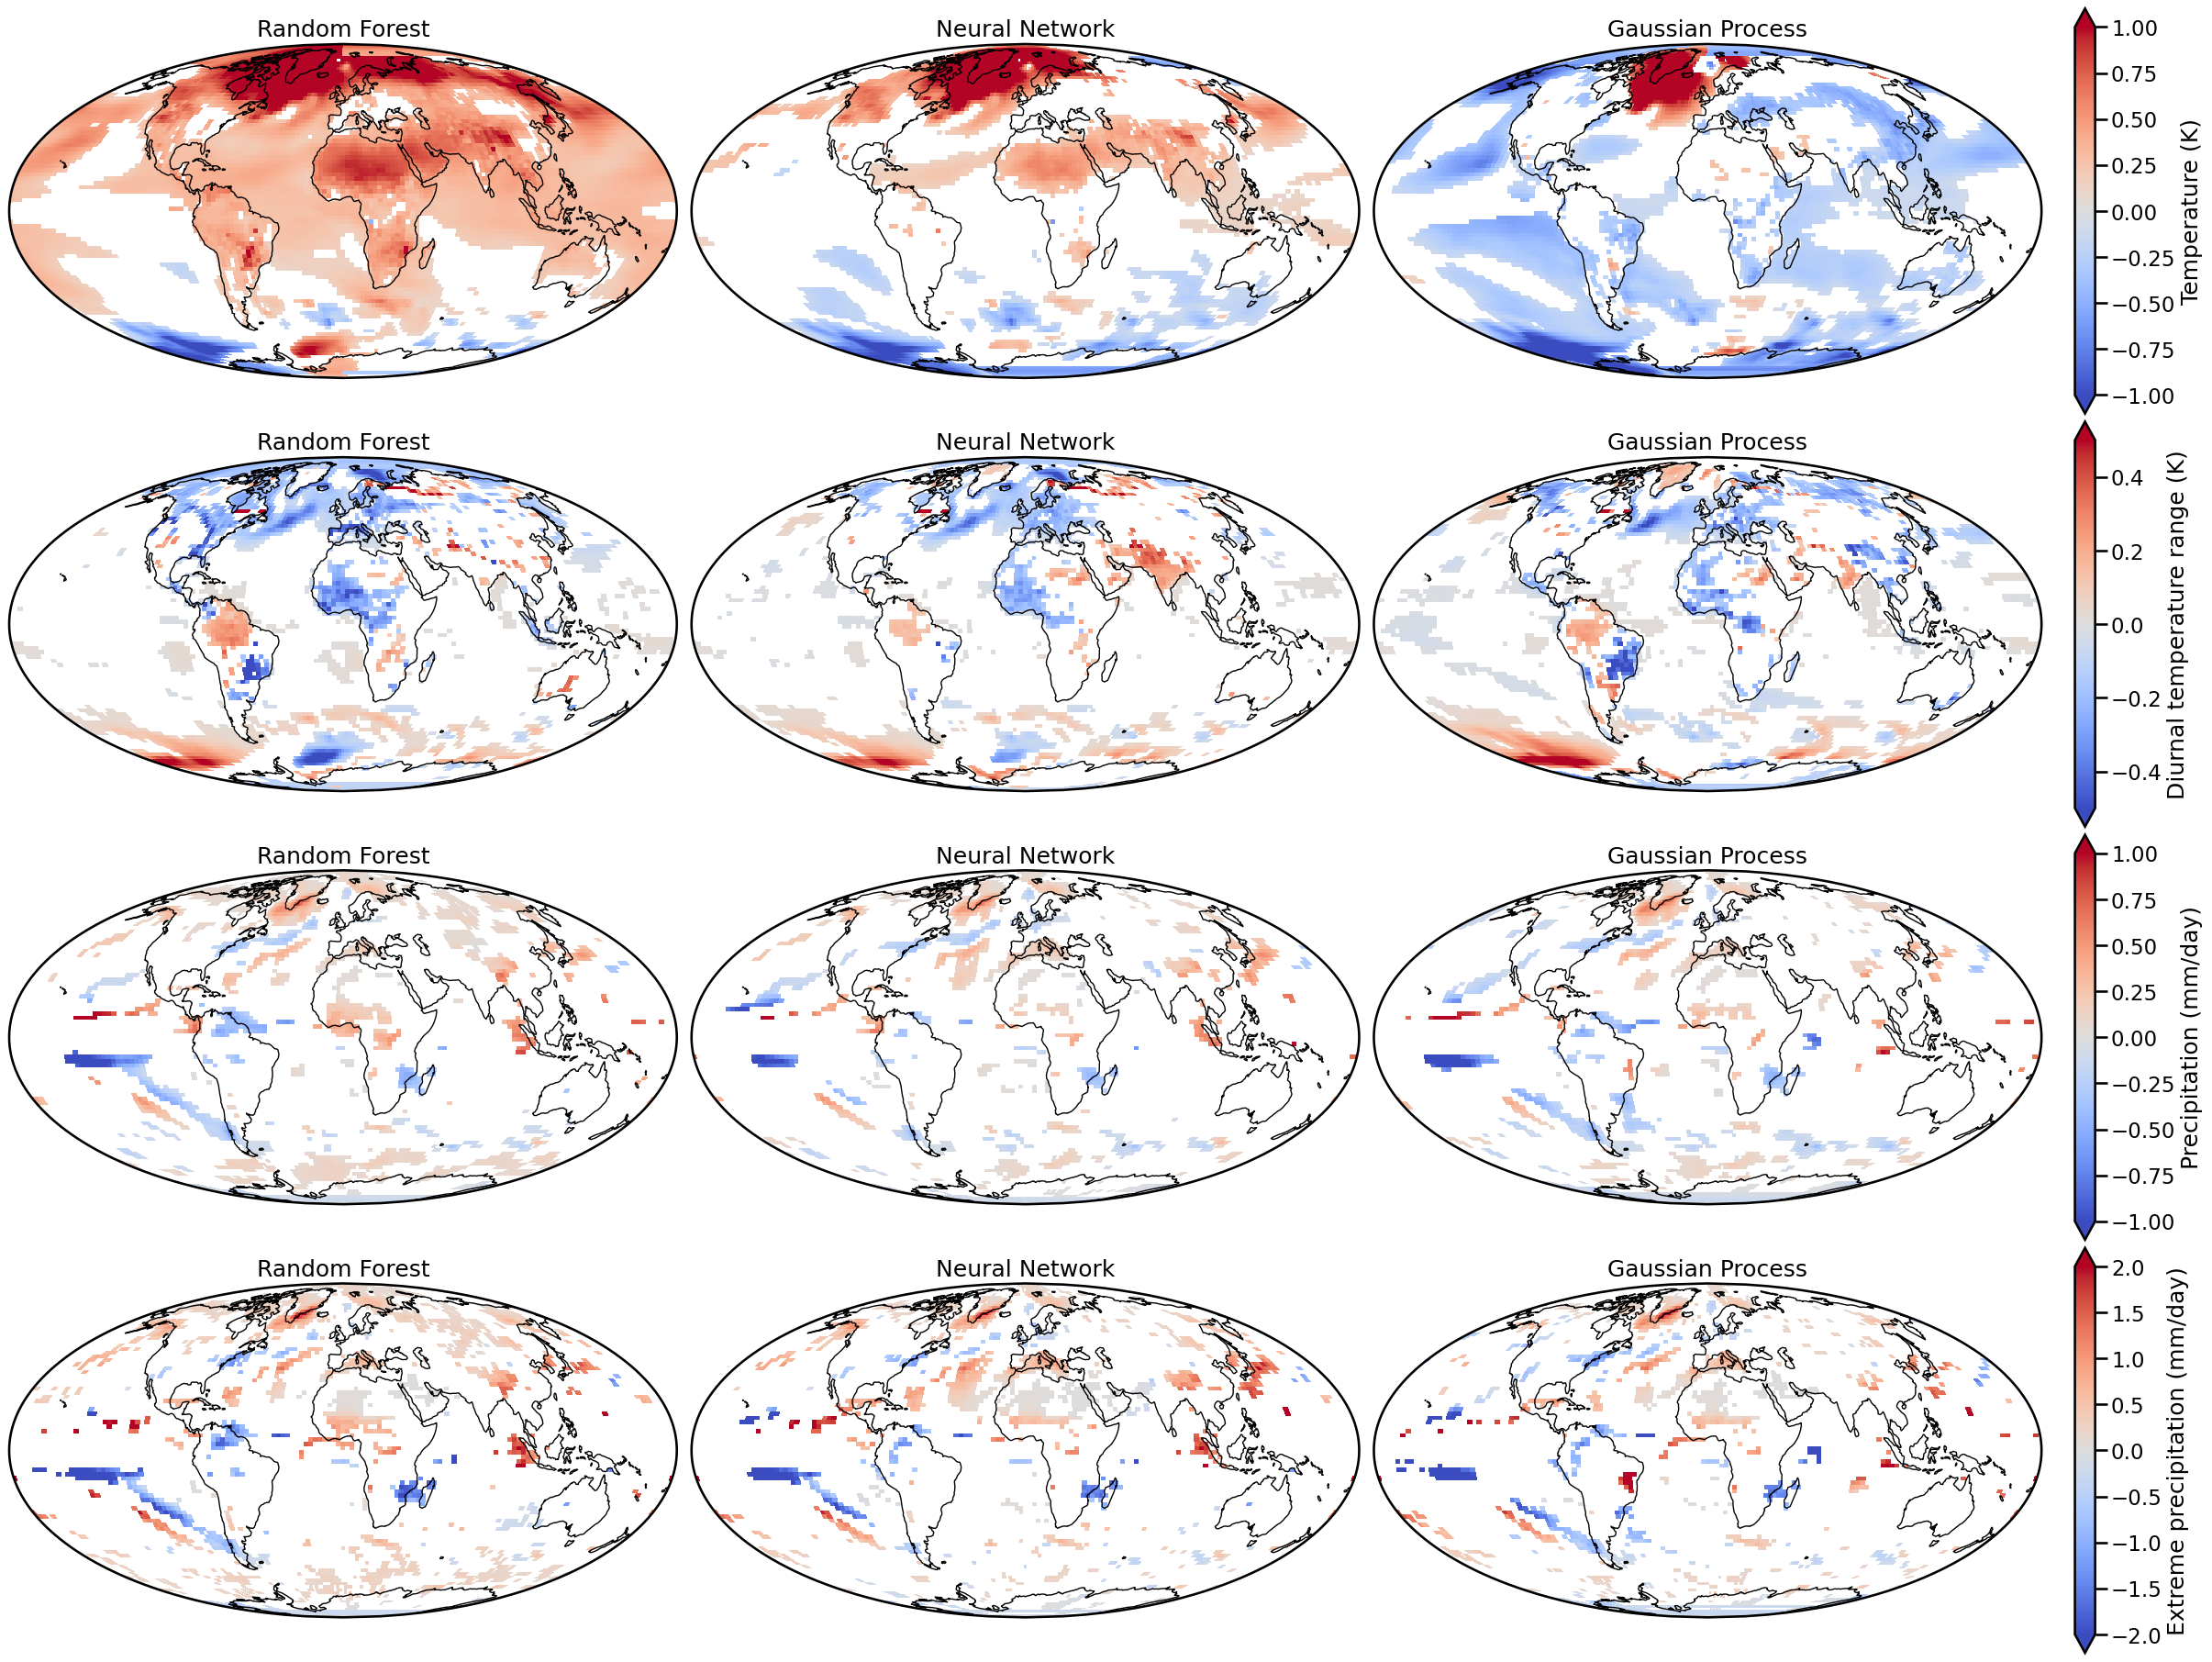

In [41]:
def ttest_rel_from_stats(diff_mean, diff_std, diff_num):
    """
    Calculates the T-test for the means of *two independent* samples of scores.

    This is a two-sided test for the null hypothesis that 2 independent samples
    have identical average (expected) values. This test assumes that the
    populations have identical variances by default.

    It is deliberately similar in interface to the other scipy.stats.ttest_... routines

    See e.g. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind_from_stats.html
    and pg. 140 in Statistical methods in Atmos Sciences
    
    :param diff: The mean difference, x_d (|x1 - x1| == |x1| - |x2|)
    :param diff_std: The standard deviation in the difference, s_d (sqrt(Var[x_d]))
    :param diff_num: The number of points, n (n == n1 == n2)
    :return float, float: t-statistic, p-value
    """
    from scipy.stats import distributions

    z = diff_mean / np.sqrt(diff_std ** 2 / diff_num)
    # use np.abs to get upper tail, then multiply by two as this is a two-tailed test
    p = distributions.t.sf(np.abs(z), diff_num - 1) * 2
    return z, p

p_level = 0.05

# proj = ccrs.PlateCarree()
kwargs = [dict(vmin=-1, vmax=1), dict(vmin=-0.5, vmax=0.5), dict(vmin=-1, vmax=1), dict(vmin=-2, vmax=2)]


with sns.plotting_context("talk"):

#     fig = plt.figure()
    fig, axes = plt.subplots(4, 3, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
    print(axes)
    for model_axes, var, label, kws in zip(axes, variables, labels, kwargs):
        for ax, model, model_label in zip(model_axes, models[1:-1], model_labels[1:-1]):
#             if label == 'Temperature (K)':
            ax.set_title(model_label)
            diff = (model[var]-models[-1][var]).sel(time=slice(2080, 2100)) # /models[-1][var]
            mean_diff = diff.mean('time')
            _, p = ttest_rel_from_stats(mean_diff, diff.std('time'), diff.count('time'))
#             p=0
            if model_label == 'Gaussian Process':
                mean_diff.where(p < p_level).plot(cmap="coolwarm", ax=ax, add_labels=False, transform=ccrs.PlateCarree(), cbar_kwargs={"label":label, "orientation":'vertical'}, **kws)
            else:
                mean_diff.where(p < p_level).plot(cmap="coolwarm", ax=ax, add_labels=False, transform=ccrs.PlateCarree(), add_colorbar=False, **kws)
            
            ax.coastlines()
                
    plt.savefig("Figure_A3.pdf")

Energetic slope: [2.] intercept: -1.0000000000000002
Random Forest slope: [16.66686594] intercept: -2.5460553387611045
Neural Network slope: [3.65385822] intercept: -0.2521633224594034
Gaussian Process slope: [4.3486808] intercept: 0.3223163706809551
NorESM2 slope: [3.99854379] intercept: -0.1258154852344795


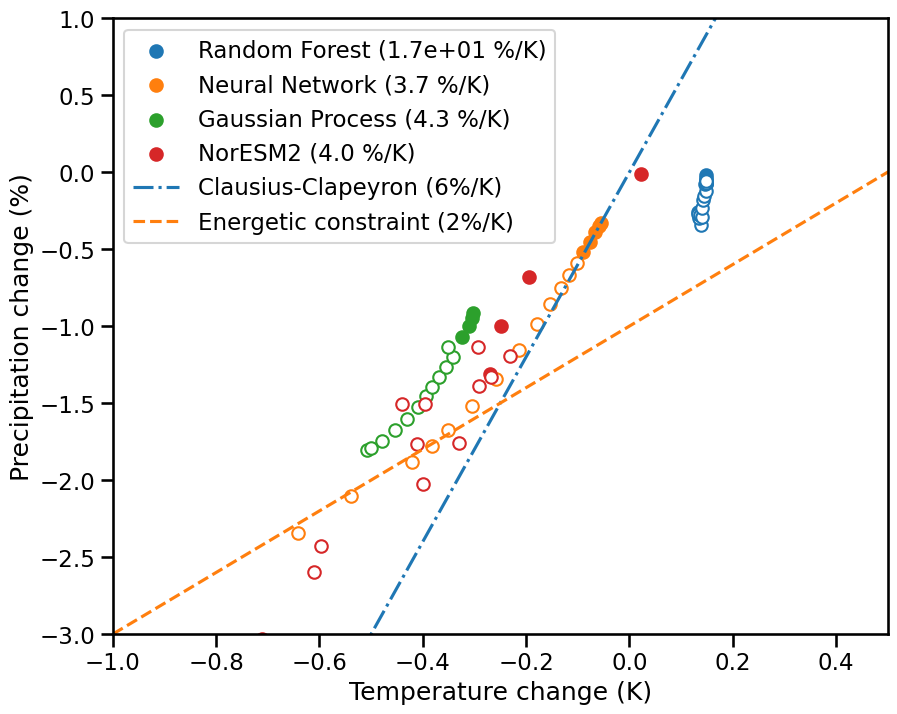

In [42]:
from sklearn.linear_model import LinearRegression

baseline_precip = 2.33511687 # From piControl

with sns.plotting_context("talk"):
    
    x = np.linspace(-1, 2.5, 100)
    
    m=LinearRegression().fit(x[:, np.newaxis], x*2-1)
    print("{} slope: {} intercept: {}".format('Energetic', m.coef_, m.intercept_))

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    for model, model_label in zip(models[1:], model_labels[1:]):
        smooth = global_mean(model).rolling(time=10).mean().dropna('time')
        smooth = global_mean(model).coarsen(time=5, boundary='pad').mean().dropna('time')
        x_, y_ = smooth['tas'], smooth['pr']/baseline_precip*100
        m=LinearRegression().fit(x_.data[:, np.newaxis], y_)

        s=ax.scatter(x_.sel(time=slice(2080, None)), y_.sel(time=slice(2080, None)), label="{} ({:0.2} %/K)".format(model_label, m.coef_[0]))
        ax.scatter(x_.sel(time=slice(None, 2080)), y_.sel(time=slice(None, 2080)), facecolor='w', edgecolor=s.get_facecolor())
        print("{} slope: {} intercept: {}".format(model_label, m.coef_, m.intercept_))
    
    plt.plot(x, x*6, label="Clausius-Clapeyron (6%/K)", ls='-.')
    plt.plot(x, x*2-1, label="Energetic constraint (2%/K)", ls='--')
    
    plt.setp(plt.gca(), xlabel="Temperature change (K)", ylabel="Precipitation change (%)", xlim=[-1, 0.5], ylim=[-3, 1])
    plt.legend(loc='upper left')

In [43]:

R2E = pd.DataFrame({
    label: {variable: rmse( global_mean(alt_Y.mean('member')[variable].sel(time=slice(2080, None))), 
                                global_mean(model[variable].sel(time=slice(2080, None)))).data/ np.abs(global_mean(alt_Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data) for variable in variables} 
    for label, model in zip(model_labels[1:-1], models[1:-1])
})
R2E.T.round(3).style.highlight_min(axis = 0, props='font-weight: bold').format("{:.4f}")

In [44]:
NRMSE = pd.DataFrame({
    label: {variable: rmse(alt_Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time'), 
                               model[variable].sel(time=slice(2080, None)).mean('time'), weights=weights).data/ np.abs(global_mean(alt_Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data) for variable in variables} 
    for label, model in zip(model_labels[1:-1], models[1:-1])
})
NRMSE.T.round(3).style.highlight_min(axis = 0, props='font-weight: bold').format("{:.4f}")

In [45]:
(NRMSE+5*R2E).T.round(3).style.highlight_min(axis = 0, props='font-weight: bold').format("{:.4f}")

In [46]:
model_labels[3:0:-1]

['Gaussian Process', 'Neural Network', 'Random Forest']

In [47]:
combined_df = pd.concat([NRMSE, R2E, NRMSE+5*R2E], keys=['Spatial', 'Global', 'Total'])[model_labels[3:0:-1]].T.swaplevel(axis=1)[variables]

In [48]:
combined_df.style.highlight_min(axis = 0, props='font-weight: bold').format("{:.3f}")